<hr>

# *Objective:* Vectorize abstracts for quick similarity comparisons between papers


# *Method:* TF-IDF Vectorization
<hr>
There are a great variety of successful document-embedding techniques, especially those emerging out of the supervised realm lead by Google's Universal Sentence Encoder. Those embedding models work well for standard english text, but will not transfer well to the biomedical domain out-of-the-box. Rather than retrain one of these complicated models, made complicated by the fact that the biomedical domain does only has a small semantic similarity dataset to benchmark and it cannot be used to compare abstracts, I will rely on research that has shown newer supervised methods do not significantly outperform BOW+TF-IDF models in unsupervised pharase similarity tasks. 

With this motivation, I will create a model for abstract similarity using the following stages:
1. Word-level tokenization
2. Normalization: lowercasing, punctuation removal, stopword removal
4. Stemmatization
5. Term frequency counting (TF)
6. Doc frequency weighting (IDF)

Biological stopwords will be provided courtesy of NCBI, and I will merge that set with the set of common english stopwords for coverage.

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import manifold
from sklearn import cluster
import os
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
import seaborn as sns
import json
from scipy import sparse
sns.set(color_codes=True)
data_dir = 'D:\datasets\covid'

In [2]:
data = pd.read_csv(os.path.join(data_dir, 'covid_data', 'metadata.csv'))

data['abstract_len'] = data['abstract'].str.split(' ').str.len()
data = data[(data.abstract_len > 50)]
data.shape

(34301, 16)

In [3]:
with open('./stopwords.txt', 'r') as f:
    bio_stopwords = [line.strip() for line in f.readlines()]

all_stopwords = list(set(stopwords.words('english')).union(set(bio_stopwords)))
len(all_stopwords), len(bio_stopwords)

(376, 313)

### Text normalization for TF-IDF model
1. Tokenize abstracts into sentences, then words
2. Lowercase only the first letter in each sentence *if and only if* that word is not fully uppercase. (This prevents over-normalization of proper nouns or accronyms which are common in biological text.)
3. Filter out punctuation
4. Filter out stopwords

##### Normalization example:
BRCA1 is an important tumor suppressor. -> [BRCA1, is, an, important, tumor, suppressor]<br>
This experiment tests BRCA1 tumor suppressing ability. -> [this, experiment, tests, BRCA1, tumor ...]

In [4]:
stemmer = SnowballStemmer('english')

def tokenize_and_lowercase(doc_str):
    return [ 
        word if (word.isupper() or i > 0) and len(word) > 1 else word.lower()
        for sent in sent_tokenize(doc_str) for i, word in enumerate(word_tokenize(sent))
        if word not in punctuation
    ]

def all_preprocess(doc_str):
    return [
        stemmer.stem(word) for word in tokenize_and_lowercase(doc_str)
        if word not in all_stopwords
    ]

count_vectorizer = sk.feature_extraction.text.CountVectorizer(
    input = 'content',
    analyzer = 'word',
    preprocessor = None,
    tokenizer = all_preprocess,
    min_df = 3,
)

term_counts = count_vectorizer.fit_transform(list(data['abstract'].values))

tf_idf_vectorizer = sk.feature_extraction.text.TfidfTransformer(
    norm = 'l2',
    use_idf = True,
    smooth_idf = True,
)

doc_models = tf_idf_vectorizer.fit_transform(term_counts)
doc_models.shape

(34301, 33694)

### Similarity Construction

With the TF-IDF vectors of 34301 abstracts calculated with 33694 unique terms, the similarity matrix between abstracts can be constructed with the dot product. Since the document vectors are l2-normalized, this dot product will give inter-document cosine similarities.

Constructing a similarity matrix for that many abstracts is a memory-intensive process, so before doing so, I will filter down to only include abstracts without important data missing and which have a full text available for analysis.

In [5]:
doc_models_df = pd.DataFrame(doc_models, index = data.index, columns = ['tf_idf_model'])

interesting_articles = data\
    .dropna(subset = ['abstract', 'title','has_full_text','publish_time', 'authors'])
interesting_articles = interesting_articles[interesting_articles.has_full_text]
interesting_articles = interesting_articles.join(doc_models_df, how = 'left')

doc_matrix = sparse.vstack([*interesting_articles['tf_idf_model'].values])
doc_matrix.shape

(23975, 33694)

In [6]:
cosine_sims = np.dot(doc_matrix, doc_matrix.transpose()).astype(np.float32).toarray()
cosine_sims.shape

(23975, 23975)

<hr>

# *Objective:* Cluster papers based on TF-IDF similarity matrix

# *Method:* Spectral Clustering
<hr>
The similarity matrix computed with the TF-IDF abstract vectors can be viewed as a weighted adjacency matrix for the graph of all papers, with more similar papers being more strongly-connected. By applying eigenvector decomposition to this adjacency matrix, one can transform the matrix from similarity space to a space where more similar papers are grouped closer together, allowing for the application of clustering algorithms, such as k-means.

I will use k-means to discover the underlying distribution of the similarity data, if any, and to group papers for analysis.

### Spectral embedding

First, I decomposed my similarity matrix, found by constructing a nearest neighbors graph. In this case I specified that each node may have 100 neighbors.

In [7]:
spectral_embedding = manifold.SpectralEmbedding(n_components=10, affinity = "precomputed",
    n_neighbors = 100, n_jobs = -1)\
    .fit_transform(cosine_sims)
spectral_embedding.shape

(23975, 10)

### Elbow Plot

In order to choose the optimal amount of clusters to apply to the data, I employed an Elbow Plot. Though the number of clusters used is recommended to be the same as the number of embedded dimensions when performing spectral clustering, I simply wanted to verify the fit with varying k.

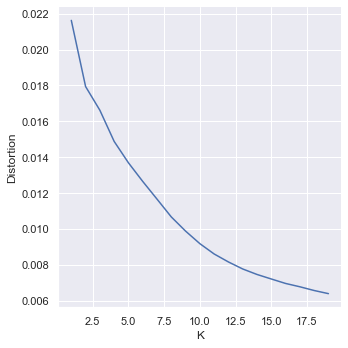

In [8]:
cluster_results = []
for k in range(1,20):
    clusters = cluster.KMeans(k, n_jobs = -1).fit(spectral_embedding)
    cluster_results.append((k, clusters.inertia_))
cluster_results_df = pd.DataFrame(cluster_results, columns = ['K','Distortion'])

sns.relplot(data = cluster_results_df, x = 'K', y = 'Distortion', kind = 'line')

### Results
There does not appear to be a distinct elbow as the number of clusters increases, but interestingly, the only noticeable kink in the curve past K=5 is at K=10. This, along with the intuition that the number of clusters should be equal to the embedding dimension allowed me to confidently choose ten clusters. Additionally, this is the maximum number of clusters I care to interpret so that works out well.

In [9]:
labels = cluster.KMeans(10, n_jobs = -1, n_init = 50).fit_predict(spectral_embedding)

### Saving Results

Each document analyzed will have an assigned cluster. To compress the space requirements of storing the similarity matrix, I will only retain the top 100 matches for each paper.

In [11]:
sims_df = pd.DataFrame(cosine_sims, index = interesting_articles.index,  columns = interesting_articles.index)

similarities_dict = {
    from_idx : {
        to_idx : sim_value
        for to_idx, sim_value in sim_series.nlargest(100).items()
    }
    for from_idx, sim_series in sims_df.iterrows()
}

with open(os.path.join(data_dir, 'analysis_v2','similarities.json'), 'w') as f:
    f.write(json.dumps(similarities_dict, indent = 4))

In [12]:
labels = pd.Series(data = labels, index = interesting_articles.index)
labels.name = 'label'

interesting_articles = data.join(labels, how = 'inner')
interesting_articles.reset_index().to_csv(
    os.path.join(data_dir, 'analysis_v2', 'metadata_plus_analysis.csv'), 
    index = False)

### Analyzing Clusters

Though the elbow plot did not show inherent clusterability in the data, I found that the clusters have heterogeneous numbers of constituent papers, suggesting some distinct clusters exist. To name the clusters, I saved 50 paper titles from each cluster and examined them for a common theme.

In [5]:
data = pd.read_csv(os.path.join(data_dir, 'analysis_v2','metadata_plus_analysis.csv')).set_index('index')

In [8]:
data.label.value_counts()

6    5094
4    4336
0    3577
3    3301
1    3237
5    1696
8    1424
9    1053
2     232
7      25
Name: label, dtype: int64

In [14]:
data.sort_values(['label','pagerank'], ascending = False).groupby('label').head(50)[['label', 'title']]\
    .to_csv('cluster_analysis.csv',index = False)